In [52]:
import torch
torch.set_default_device("cuda")
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from datasets import load_dataset

dataset = load_dataset("iwslt2017", "iwslt2017-en-fr")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 232825
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8597
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 890
    })
})


In [53]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [54]:
train_data[0]

{'translation': {'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.",
  'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}}

In [55]:
from tqdm import tqdm

# Function to get English and French sentences from the dataset
def get_en_fr_sentences(data):
    english = [item['en'] for item in tqdm(data['translation'])]
    french = [item['fr'] for item in tqdm(data['translation'])]
    return english, french

In [56]:
train_en, train_fr = get_en_fr_sentences(train_data)

# just for testing
train_en = train_en[:10000]
train_fr = train_fr[:10000]

val_en, val_fr = get_en_fr_sentences(val_data)

# just for testing
val_en = val_en[:200]
val_fr = val_fr[:200]

test_en, test_fr = get_en_fr_sentences(test_data)

# just for testing
test_en = test_en[:1000]
test_fr = test_fr[:1000]

100%|██████████| 8597/8597 [00:00<?, ?it/s]


In [57]:
train_en[0]

"Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful."

In [58]:
train_fr[0]

"Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."

In [59]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize sentences
def tokenize(sentences, tokenizer):
    tokenized_sentences = tokenizer(
        sentences,
        truncation=True,
        padding=True,
        add_special_tokens=True,
        return_tensors="pt",
        max_length=512
    )
    return tokenized_sentences

In [60]:
tokenized_train_en = tokenize(train_en, tokenizer)
tokenized_train_fr = tokenize(train_fr, tokenizer)

tokenized_val_en = tokenize(val_en, tokenizer)
tokenized_val_fr = tokenize(val_fr, tokenizer)

tokenized_test_en = tokenize(test_en, tokenizer)
tokenized_test_fr = tokenize(test_fr, tokenizer)

In [61]:
tokenized_train_en.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [62]:
class TranslationDataset(Dataset):
    def __init__(self, tokenized_source, tokenized_target):
        self.source_tokens = tokenized_source["input_ids"]
        self.target_tokens = tokenized_target["input_ids"]

    def __len__(self):
        return len(self.source_tokens)

    def __getitem__(self, index):
        source_sequence = self.source_tokens[index]
        target_sequence = self.target_tokens[index]

        return {
            "input_ids": source_sequence,
            "labels": target_sequence,
        }

# Create datasets
train_dataset = TranslationDataset(tokenized_train_en, tokenized_train_fr)
val_dataset = TranslationDataset(tokenized_val_en, tokenized_val_fr)
test_dataset = TranslationDataset(tokenized_test_en, tokenized_test_fr)

In [63]:
from torchscale.architecture.config import EncoderConfig
from torchscale.architecture.encoder import Encoder
from torchscale.component.embedding import PositionalEmbedding, TextEmbedding

enc_config = EncoderConfig(
    encoder_embed_dim=64,
    encoder_attention_heads=8,
    encoder_ffn_embed_dim=256,
    encoder_layers=8,
    max_source_positions=512,
    vocab_size=30000
)
encoder = Encoder(
    enc_config,
    embed_tokens=TextEmbedding(30000, enc_config.encoder_embed_dim),
    embed_positions=PositionalEmbedding(enc_config.max_source_positions, enc_config.encoder_embed_dim)
)

# Print model arch
print(encoder)

Encoder(
  (dropout_module): Dropout(p=0.0, inplace=False)
  (embed_tokens): TextEmbedding(30000, 64)
  (embed_positions): PositionalEmbedding(512, 64)
  (output_projection): Linear(in_features=64, out_features=30000, bias=False)
  (layers): ModuleList(
    (0-7): 8 x EncoderLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=64, out_features=64, bias=True)
        (v_proj): Linear(in_features=64, out_features=64, bias=True)
        (q_proj): Linear(in_features=64, out_features=64, bias=True)
        (out_proj): Linear(in_features=64, out_features=64, bias=True)
        (inner_attn_ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout_module): Dropout(p=0.0, inplace=False)
      )
      (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout_module): Dropout(p=0.0, inplace=False)
      (ffn): FeedForwardNetwork(
        (activation_dropout_module): Dropout(p=0.0, inplace=False)
        (dropout_modu

In [64]:
from torchscale.architecture.config import RetNetConfig
from torchscale.architecture.retnet import RetNetDecoder

ret_config = RetNetConfig(
    decoder_embed_dim=64,
    decoder_value_embed_dim=128,
    decoder_retention_heads=4,
    decoder_ffn_embed_dim=256,
    decoder_layers=8,
    max_target_positions=512,
    vocab_size=30000
)
retnet = RetNetDecoder(
    ret_config,
    embed_tokens=TextEmbedding(30000, ret_config.decoder_embed_dim),
)

# Print retnet arch
print(retnet)

RetNetDecoder(
  (dropout_module): Dropout(p=0.0, inplace=False)
  (embed_tokens): TextEmbedding(30000, 64)
  (output_projection): Linear(in_features=64, out_features=30000, bias=False)
  (layers): ModuleList(
    (0-7): 8 x DecoderLayer(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (retention): MultiScaleRetention(
        (q_proj): Linear(in_features=64, out_features=64, bias=False)
        (k_proj): Linear(in_features=64, out_features=64, bias=False)
        (v_proj): Linear(in_features=64, out_features=128, bias=False)
        (g_proj): Linear(in_features=64, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
        (group_norm): RMSNorm()
      )
      (retention_layer_norm): RMSNorm()
      (ffn): GLU(
        (activation_dropout_module): Dropout(p=0.0, inplace=False)
        (dropout_module): Dropout(p=0.0, inplace=False)
        (fc1): Linear(in_features=64, out_features=256, bias=False)
        (fc2): Linear(i

In [65]:
# Define optimizers for the encoder and decoder
encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-5)
retnet_optimizer = torch.optim.AdamW(retnet.parameters(), lr=1e-5)

In [66]:
batch_size = 4

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [67]:
criterion = nn.CrossEntropyLoss()

In [68]:
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    encoder.train()
    retnet.train()

    total_loss = 0

    for batch in tqdm(train_loader):
        encoder_optimizer.zero_grad()
        retnet_optimizer.zero_grad()

        src_tokens = batch['input_ids']
        prev_output_tokens = batch['labels']
        target_sequence = batch['labels']

        encoder_output = encoder(src_tokens)
        retnet_output, _ = retnet(prev_output_tokens)

        loss = criterion(retnet_output.view(-1, ret_config.vocab_size), target_sequence.view(-1))

        loss.backward()

        encoder_optimizer.step()
        retnet_optimizer.step()

        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    print(f"Epoch {epoch + 1}, Training loss: {average_loss}")

    encoder.eval()
    retnet.eval()

    with torch.no_grad():
        total_val_loss = 0

        for val_batch in tqdm(val_loader):

            val_src_tokens = val_batch["input_ids"]
            val_prev_output_tokens = val_batch["labels"]

            encoder_output = encoder(val_src_tokens)
            retnet_output, _ = retnet(val_prev_output_tokens)

            val_loss = criterion(retnet_output.view(-1, ret_config.vocab_size), val_batch['labels'].view(-1))
            total_val_loss += val_loss.item()
        
        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        print(f"Epoch {epoch + 1}, Validation Loss: {average_val_loss}")

100%|██████████| 2500/2500 [02:15<00:00, 18.50it/s]


Epoch 1, Training loss: 3.053144137477875


100%|██████████| 50/50 [00:01<00:00, 40.87it/s]


Epoch 1, Validation Loss: 1.9275400519371033


100%|██████████| 2500/2500 [02:18<00:00, 18.11it/s]


Epoch 2, Training loss: 1.2831998250961303


100%|██████████| 50/50 [00:01<00:00, 39.52it/s]


Epoch 2, Validation Loss: 1.0274717092514039


100%|██████████| 2500/2500 [02:16<00:00, 18.31it/s]


Epoch 3, Training loss: 0.7197414883077144


100%|██████████| 50/50 [00:01<00:00, 40.98it/s]


Epoch 3, Validation Loss: 0.6710742244124412


100%|██████████| 2500/2500 [02:15<00:00, 18.47it/s]


Epoch 4, Training loss: 0.4694631684362888


100%|██████████| 50/50 [00:01<00:00, 41.83it/s]


Epoch 4, Validation Loss: 0.48189415216445924


100%|██████████| 2500/2500 [02:16<00:00, 18.30it/s]


Epoch 5, Training loss: 0.3307826317638159


100%|██████████| 50/50 [00:01<00:00, 44.04it/s]


Epoch 5, Validation Loss: 0.3675372187793255


100%|██████████| 2500/2500 [02:16<00:00, 18.28it/s]


Epoch 6, Training loss: 0.24581361654251813


100%|██████████| 50/50 [00:01<00:00, 39.73it/s]


Epoch 6, Validation Loss: 0.2924006718397141


100%|██████████| 2500/2500 [02:16<00:00, 18.37it/s]


Epoch 7, Training loss: 0.19017170282900334


100%|██████████| 50/50 [00:01<00:00, 41.74it/s]


Epoch 7, Validation Loss: 0.2401502275466919


100%|██████████| 2500/2500 [02:19<00:00, 17.97it/s]


Epoch 8, Training loss: 0.1516255485147238


100%|██████████| 50/50 [00:01<00:00, 42.85it/s]


Epoch 8, Validation Loss: 0.20236011482775212


100%|██████████| 2500/2500 [02:18<00:00, 18.11it/s]


Epoch 9, Training loss: 0.12369414857886732


100%|██████████| 50/50 [00:01<00:00, 38.32it/s]


Epoch 9, Validation Loss: 0.1739048755168915


100%|██████████| 2500/2500 [02:15<00:00, 18.48it/s]


Epoch 10, Training loss: 0.10271770230270923


100%|██████████| 50/50 [00:01<00:00, 41.26it/s]

Epoch 10, Validation Loss: 0.1518898917734623


In [69]:
encoder.eval()
retnet.eval()

with torch.no_grad():
    total_test_loss = 0

    for test_batch in tqdm(test_loader):

        test_src_tokens = test_batch["input_ids"]
        test_prev_output_tokens = test_batch["labels"]

        encoder_output = encoder(test_src_tokens)
        retnet_output, _ = retnet(test_prev_output_tokens)

        val_loss = criterion(retnet_output.view(-1, ret_config.vocab_size), test_batch['labels'].view(-1))
        total_test_loss += val_loss.item()
    
    average_test_loss = total_test_loss / len(test_loader)

    print(f"Final Test loss: {average_test_loss}")

100%|██████████| 250/250 [00:06<00:00, 41.39it/s]

Final Test loss: 0.1142873937562108


In [70]:
from torchtext.data.metrics import bleu_score

encoder.eval()
retnet.eval()

candidate_corpus = []
reference_corpus = []

with torch.no_grad():
    for batch in tqdm(train_loader):
        src_tokens = batch['input_ids']
        prev_output_tokens = batch['labels']

        encoder_output = encoder(src_tokens)
        retnet_output, _ = retnet(prev_output_tokens)

        predictions = torch.argmax(retnet_output, dim=-1)

        # Convert token IDs to strings
        candidates = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions.cpu().numpy().tolist()]
        candidate_corpus.extend(candidates)

        references = [tokenizer.decode(seq, skip_special_tokens=True).split() for seq in batch['labels'].cpu().numpy().tolist()]
        reference_corpus.extend(references)

candidate_corpus = [str(candidate) for candidate in candidate_corpus]

bleu = bleu_score(candidate_corpus, reference_corpus)
print(f"BLEU score: {bleu}")

100%|██████████| 2500/2500 [01:26<00:00, 28.76it/s]


BLEU score: 0.3406278192996979


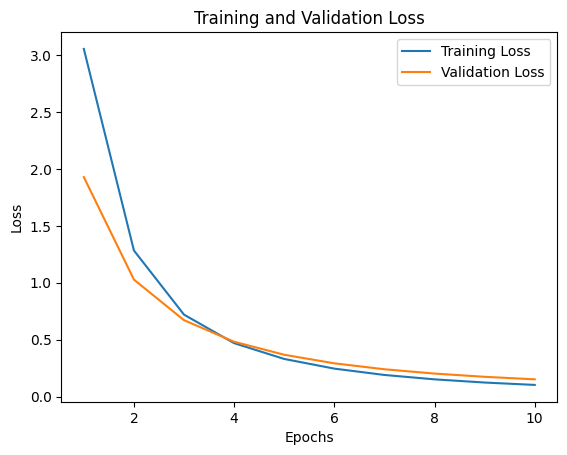

In [71]:
import matplotlib.pyplot as plt 
%matplotlib inline 

epochs = range(1, 11)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()